In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [2]:
from load_dataset import Dataset

In [3]:
dataset = Dataset('../data/dataset/')

In [4]:
# возьмем временной ряд, характеризующий продажи алкоголя по месяцам
ts = dataset["alcohol_sales.csv"]

In [32]:
ts, ts_test = ts[:250], ts[250:]

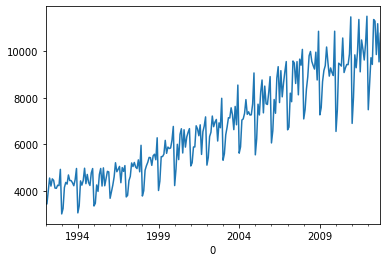

In [34]:
ts.plot()

In [35]:
# как можно заметить, у него есть окололинейный тренд, гетероскедастичность, сезонный период равен 12 (месяцам)

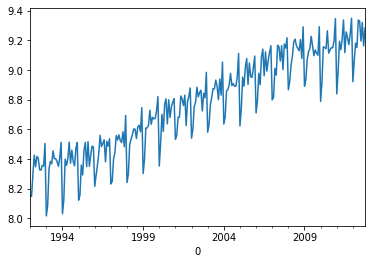

In [36]:
# сначала уберем гетероскедастичность простым логарифмированием
ts_log = np.log(ts)
ts_log.plot()

In [37]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [38]:
# для начала просто продифференцируем один раз

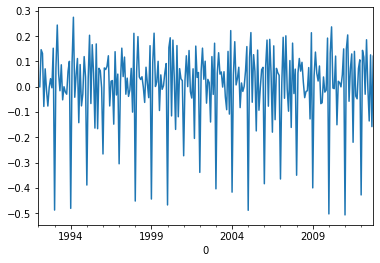

In [39]:
# данный ряд недостаточно стационарен, т.к сохраняет сезонность
ts_log.diff().plot()

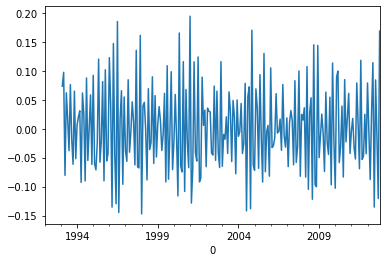

In [40]:
# попробуем применить сезонное дифференцирование 
ts_log.diff().diff(12).plot()

In [41]:
# уже лучше
# посмотрим, что скажет критерий Дики Фуллера
adfuller(ts_log.diff().diff(12).dropna())[1]

2.9448496463561783e-10

In [42]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 1)

In [43]:
# теперь разберемся с параметрами q, Q, p, P.
# Для этого сначала уберем тренд, чтобы он не искажал график автокорреляций.

In [44]:
ts_flat = pd.Series(detrend(ts_log), ts_log.index)

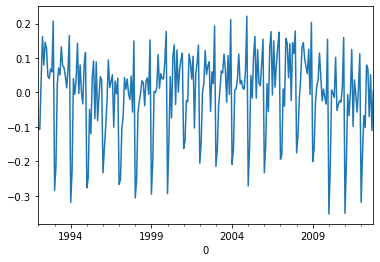

In [45]:
# тут, кстати, мы сразу можем заметить, что помимо сезонности мы имеем цикличность порядка 10 лет длинной 
ts_flat.plot()

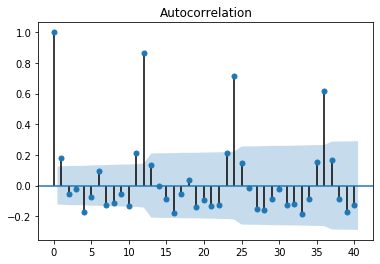

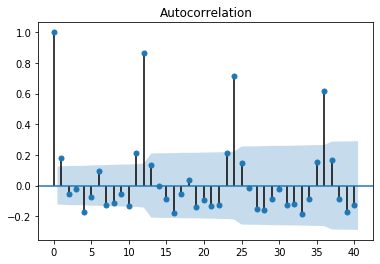

In [46]:
# отлично, для поиска параметров q, Q нарисуем график автокорреляций
# последний значимый несезонный лаг определяется как последний лаг, котоырй еще не пересек
# интервал значимости по модулю (то есть ВСЕ лаги от нулевого до него были выше порога значимости).
# В данном случае он равено одному (не забываем, что считаем мы с нуля - нулевого лага). Итак q = 1
plot_acf(ts_flat, lags=40)

In [47]:
# Теперь разберемся с оценкой для сезонного лага Q. Для этого нарисуем тот же график автокорреляций, но с большим
# горизонтом лагов

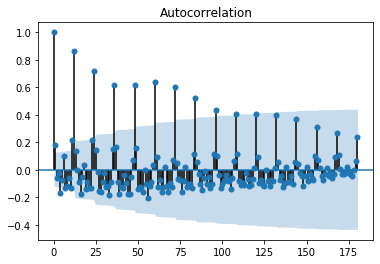

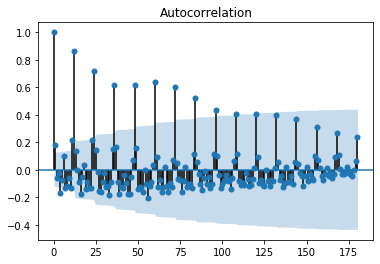

In [48]:
# на данном графике мы видим, что у нас помимо нашей сезонности присутствует квартальная сезонность!
# сезонность, которую "по умолчанию" модель arima не учитывает, поэтому последний значимый сезонный лаг
# в данном случае это первый 12-месячный сезонный лаг, достигший минимума, т.е. Q = 3 
plot_acf(ts_flat, lags=180)

/Users/gsinyakov/ts_course/.env/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



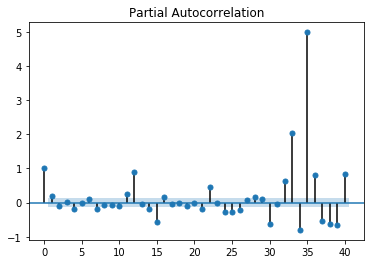

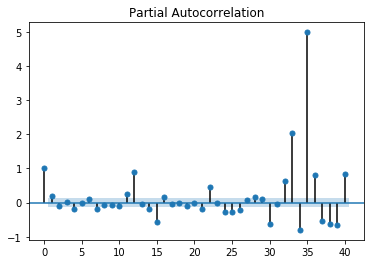

In [49]:
# теперь разберемся с параметрами p, P
# здесь видно, что последний значимый несезонный лаг равен одному (третий лаг внизу уже достиг порога значимости)
# а последний значимый сезонный лаг равен 1 (на самом деле если построить график дальше,
# то там будут еще сезонные лаги, но незначительно превышающие порог значимости лаги большого порядка обычно
# игнорируются)
# итак, p = 1, P = 1
plot_pacf(ts_flat, lags=40)

In [50]:
# теперь попробуем построить SARIMA с этими параметрами

In [51]:
from statsmodels.tsa.statespace import sarimax

In [52]:
model = sarimax.SARIMAX(ts, order=(1, 1, 2), seasonal_order=(1, 1, 3, 12))

/Users/gsinyakov/ts_course/.env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [53]:
res = model.fit()

/Users/gsinyakov/ts_course/.env/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [58]:
preds = res.forecast(69)

In [64]:
plotting.plot_multiple_ts(ts, preds)

In [65]:
# Видим что получилось весьма неплохо!

In [66]:
# дальнейший подбор гиперпараметров можно осуществить используя критерий Акаике

In [67]:
from metrics import mase

In [68]:
mase(preds, ts_test)

0.2777635205110843